In [1]:
# using two datasets, they are 20newsgroups and Reuters-21578
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import reuters

from __future__ import absolute_import
from __future__ import print_function
import os
import sys
import re
import math
import numpy as np
from pprint import pprint
from time import time
import random
import json
import collections
from itertools import compress

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import pairwise_distances

import tensorflow as tf

import keras
from keras.datasets import reuters as reuters2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers.recurrent import LSTM

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# import functions for draw the graph of models
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import pydot
# import gensim

Using TensorFlow backend.


# Part 1 Loading Datasets and Classify Documents with Baselines

Two baseline system is used: one is a multilayer perceptron and the other is support vector machine.
Both of them classify documents using tf-idf vectors of documents.

In [2]:
def load_dataset(dataset_name):
    docs_train = []
    docs_test = []
    y_train = []
    y_test = []
    target_names = []
    
    # using reuters dataset from keras package
    if dataset_name == 'reuters':
#         target_names = reuters.categories()
#         for doc_id in reuters.fileids():
#             file_target_list = reuters.categories(doc_id)
#             if doc_id.startswith("train"):
#                 docs_train.append(reuters.raw(doc_id))
#                 y = []
#                 for file_target in file_target_list:                    
#                     y.append(target_names.index(file_target))
#                 y_train.append(y)
#             else:
#                 docs_test.append(reuters.raw(doc_id))
#                 y = []
#                 for file_target in file_target_list:
#                     y.append(target_names.index(file_target))
#                 y_test.append(y)
        word_index = reuters2.get_word_index(path="reuters_word_index.json")
        inverse_word_dict = np.ndarray(shape=(len(word_index)+1,), dtype=object)
        for key in word_index:
            index = word_index[key]
            inverse_word_dict[index] = key

        print('Loading reuters dataset...')
        (x_train, y_train), (x_test, y_test) = reuters2.load_data(test_split=0.2)
        
        for x in x_train:
            x = [t for t in x if t < len(word_index)]
            docs_train.append(' '.join(inverse_word_dict[x]))
        print(len(docs_train), 'train docs', len(y_train))
        
        for x in x_test:
            x = [t for t in x if t < len(word_index)]
            docs_test.append(' '.join(inverse_word_dict[x]))
        print(len(docs_test), 'test docs', len(y_test))
        
        target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                        '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                        '1', '2', '3', '4', '5', '6']
    elif dataset_name == '20newsgroups':
        newsgroups_train = fetch_20newsgroups(subset='train')
        docs_train = newsgroups_train.data
        y_train = newsgroups_train.target
        newsgroups_test = fetch_20newsgroups(subset='test')
        docs_test = newsgroups_test.data
        y_test = newsgroups_test.target
        target_names = newsgroups_train.target_names
    
    print(len(docs_train), "training documents are loaded.")
    print(len(docs_test), "test documents are loaded.\n")
    
    return docs_train, y_train, docs_test, y_test, np.array(target_names)

# convert documents to bag of word vectors
def doc_2_matrix(vocab_size, docs_train, y_train, docs_test, y_test):
    
    MAX_NB_WORDS = vocab_size
    MAX_SEQUENCE_LENGTH = 2000
    
    # fit the tokenizer with the corpus
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    docs = []
    docs.extend(docs_train)
    docs.extend(docs_test)
    tokenizer.fit_on_texts(docs)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    # vectorize texts into 2D integer tensors
    # mode: "binary", "count", "tfidf", "freq" (default: "binary")
    x_train_m = tokenizer.texts_to_matrix(docs_train, mode='tfidf')
    y_train_m = to_categorical(np.asarray(y_train))
    print('Shape of x_train_m:', x_train_m.shape)
    print('Shape of y_train_m:', y_train_m.shape)
    
    x_test_m = tokenizer.texts_to_matrix(docs_test, mode='tfidf')
    y_test_m = to_categorical(np.asarray(y_test))
    print('Shape of x_test_m:', x_test_m.shape)
    print('Shape of y_test_m:', y_test_m.shape)
    
    return x_train_m, y_train_m, x_test_m, y_test_m

# convert documents to word index sequences
def doc_2_sequences(docs_train, y_train, docs_test, y_test):
    # vectorize the text samples into a 2D integer tensor
    MAX_NB_WORDS = 60000
    MAX_SEQUENCE_LENGTH = 2000
    
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    docs = []
    docs.extend(docs_train)
    docs.extend(docs_test)
    tokenizer.fit_on_texts(docs)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    x_train_m = pad_sequences(tokenizer.texts_to_sequences(docs_train), maxlen=MAX_SEQUENCE_LENGTH)
    y_train_m = to_categorical(np.asarray(y_train))
    print('Shape of x_train_m:', x_train_m.shape)
    print('Shape of y_train_m:', y_train_m.shape)
    
    x_test_m = pad_sequences(tokenizer.texts_to_sequences(docs_test), maxlen=MAX_SEQUENCE_LENGTH)
    y_test_m = to_categorical(np.asarray(y_test))
    print('Shape of x_test_m:', x_test_m.shape)
    print('Shape of y_test_m:', y_test_m.shape)
    
    return x_train_m, y_train_m, x_test_m, y_test_m

class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return 0.9 * x * K.sigmoid(0.8015*x)

get_custom_objects().update({'swish': Swish(swish)})

def mlp_base_line(vocab_size, num_classes, x_train_m, y_train_m, x_test_m, y_test_m, epochs, dataset, isload, outfile):
    
    model = Sequential()
    
    if isload == False:
        print('Building a MLP baseline model...')
        model.add(Dense(512, input_shape=(vocab_size,)))
        model.add(Activation('tanh'))
        model.add(Dropout(0.75))
        model.add(Dense(300))
        model.add(Activation('swish'))
        model.add(Dropout(0.7))
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    else:
        print('loading a pretrained MLP model...')
        model = load_model('Model/' + dataset + outfile + '.h5')
    
    # show picture of the trained model
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    
    batch_size = 128
    history = model.fit(x_train_m, y_train_m,
                        batch_size = batch_size,
                        epochs = epochs,
                        verbose = 1,
                        validation_split = 0.1)
    model.save('Model/' + dataset + outfile + '.h5')

    score = model.evaluate(x_test_m, y_test_m, batch_size = batch_size, verbose = 1)
    print('\nTest score:', score[0], 'Test accuracy:', score[1])
    
def svm_test(X, y, C1, X_test, y_test, C2):
    for c_value in C1:
        clf = svm.SVC(C=c_value, gamma=1/len(X[0]))
        start = time()
        clf.fit(X, y)
        end = time()
        y_pred = clf.predict(X_test)

        counter = 0;
        for idx, pred in enumerate(y_pred):
            if y_test[idx] != pred:
                counter = counter + 1
        print("RBF: Correct rate =", 1 - counter/len(y_test), " When C =", c_value, "Training time = ", (end - start))
        
    for c_value in C2:
        lin_clf = svm.LinearSVC(C=c_value)
        start = time()
        lin_clf.fit(X, y)
        end = time()
        y_pred = lin_clf.predict(X_test)

        counter = 0;
        for idx, pred in enumerate(y_pred):
            if y_test[idx] != pred:
                counter = counter + 1
        print("Linear: Correct rate =", 1 - counter/len(y_test), " When C =", c_value, "Training time = ", (end - start))

#### Using MLP to classifiy documents

Loading reuters dataset...
8982 train docs 8982
2246 test docs 2246
8982 training documents are loaded.
2246 test documents are loaded.

Found 30976 unique tokens.
Shape of x_train_m: (8982, 30000)
Shape of y_train_m: (8982, 46)
Shape of x_test_m: (2246, 30000)
Shape of y_test_m: (2246, 46)
46 targets

loading a pretrained MLP model...


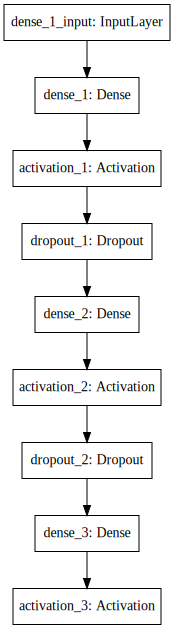

Train on 8083 samples, validate on 899 samples
Epoch 1/6
8083/8083 [==============================] - 19s 2ms/step - loss: 0.0300 - acc: 0.9899 - val_loss: 2.0687 - val_acc: 0.8087
Epoch 2/6
8083/8083 [==============================] - 18s 2ms/step - loss: 0.0263 - acc: 0.9904 - val_loss: 2.0978 - val_acc: 0.8065
Epoch 3/6
8083/8083 [==============================] - 18s 2ms/step - loss: 0.0209 - acc: 0.9926 - val_loss: 2.1088 - val_acc: 0.8042
Epoch 4/6
8083/8083 [==============================] - 18s 2ms/step - loss: 0.0206 - acc: 0.9934 - val_loss: 2.1275 - val_acc: 0.8065
Epoch 5/6
8083/8083 [==============================] - 18s 2ms/step - loss: 0.0203 - acc: 0.9938 - val_loss: 2.1575 - val_acc: 0.8042
Epoch 6/6
2246/2246 [==============================] - 2s 700us/step

Test score: 2.06133476009 Test accuracy: 0.810774711021


In [6]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('reuters')
vocab_size = 30000
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_matrix(vocab_size, docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')
mlp_base_line(x_train_m.shape[1], len(target_names), x_train_m, y_train_m, x_test_m, y_test_m, 6, 'reuters', True, 'MLP_out')

11314 training documents are loaded.
7532 test documents are loaded.

Found 179209 unique tokens.
Shape of x_train_m: (11314, 30000)
Shape of y_train_m: (11314, 20)
Shape of x_test_m: (7532, 30000)
Shape of y_test_m: (7532, 20)
20 targets

Building a MLP baseline model...


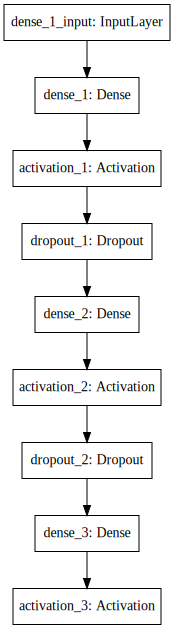

Train on 10182 samples, validate on 1132 samples
Epoch 1/60
10182/10182 [==============================] - 25s 2ms/step - loss: 1.8074 - acc: 0.4772 - val_loss: 0.4179 - val_acc: 0.9055
Epoch 2/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.5305 - acc: 0.8462 - val_loss: 0.2728 - val_acc: 0.9276
Epoch 3/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.2781 - acc: 0.9177 - val_loss: 0.2327 - val_acc: 0.9311
Epoch 4/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.1720 - acc: 0.9492 - val_loss: 0.2289 - val_acc: 0.9320
Epoch 5/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.1211 - acc: 0.9633 - val_loss: 0.2409 - val_acc: 0.9329
Epoch 6/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.0907 - acc: 0.9733 - val_loss: 0.2438 - val_acc: 0.9276
Epoch 7/60
10182/10182 [==============================] - 23s 2ms/step - loss: 0.0719 - acc: 0.9788 - val_loss: 0.2537 - val_acc:

7532/7532 [==============================] - 5s 663us/step

Test score: 1.22736538666 Test accuracy: 0.846123208059


In [3]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('20newsgroups') # 20newsgroups
vocab_size = 30000
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_matrix(vocab_size, docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')
mlp_base_line(x_train_m.shape[1], len(target_names), x_train_m, y_train_m, x_test_m, y_test_m, 60, 'news', False, 'MLP_out')

#### Using SVM to classify documents

In [4]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('reuters') # 20newsgroups reuters
vocab_size = 30000
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_matrix(vocab_size, docs_train, y_train, docs_test, y_test)
C1 = [8, 16, 32, 64, 128, 256] # RBF
C2 = [0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.5, 1.0] # Linear
print(len(target_names), 'targets\n')
svm_test(x_train_m, y_train, C1, x_test_m, y_test, C2)

Loading reuters dataset...
8982 train docs 8982
2246 test docs 2246
8982 training documents are loaded.
2246 test documents are loaded.

Found 30976 unique tokens.
Shape of x_train_m: (8982, 30000)
Shape of y_train_m: (8982, 46)
Shape of x_test_m: (2246, 30000)
Shape of y_test_m: (2246, 46)
46 targets

RBF: Correct rate = 0.8067675868210151  When C = 8 Training time =  5036.703392744064
RBF: Correct rate = 0.8107747105966162  When C = 16 Training time =  5432.142902851105
RBF: Correct rate = 0.8116651825467498  When C = 32 Training time =  5435.881803750992
RBF: Correct rate = 0.8125556544968834  When C = 64 Training time =  4670.658353567123
RBF: Correct rate = 0.8094390026714159  When C = 128 Training time =  4212.804310321808
RBF: Correct rate = 0.8081032947462155  When C = 256 Training time =  4169.693519592285
Linear: Correct rate = 0.8063223508459484  When C = 5e-05 Training time =  2.9477622509002686
Linear: Correct rate = 0.8227960819234195  When C = 0.0001 Training time =  2.4

In [8]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('20newsgroups') # 20newsgroups reuters
vocab_size = 30000
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_matrix(vocab_size, docs_train, y_train, docs_test, y_test)
C1 = [8, 16, 32, 64, 128, 256] # RBF
C2 = [0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.5, 1.0] # Linear
print(len(target_names), 'targets\n')
svm_test(x_train_m, y_train, C1, x_test_m, y_test, C2)

11314 training documents are loaded.
7532 test documents are loaded.

Found 179209 unique tokens.
Shape of x_train_m: (11314, 30000)
Shape of y_train_m: (11314, 20)
Shape of x_test_m: (7532, 30000)
Shape of y_test_m: (7532, 20)
20 targets

RBF: Correct rate = 0.8167817312798725  When C = 8 Training time =  4681.928590774536
RBF: Correct rate = 0.8230217737652682  When C = 16 Training time =  4656.582355499268
RBF: Correct rate = 0.8193043016463091  When C = 32 Training time =  4678.8241930007935
RBF: Correct rate = 0.8194370685077005  When C = 64 Training time =  4537.1960327625275
RBF: Correct rate = 0.8185077004779607  When C = 128 Training time =  4282.653331756592
RBF: Correct rate = 0.8187732342007434  When C = 256 Training time =  3971.236307859421
Linear: Correct rate = 0.8572756240042485  When C = 5e-05 Training time =  3.735177516937256
Linear: Correct rate = 0.8596654275092936  When C = 0.0001 Training time =  3.1842267513275146
Linear: Correct rate = 0.8570100902814657  When

# Part 2 Recurrent Neural Network With Word Embeddings

In [12]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'Dataset')
vocab_size = 60000
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 300

print('Loading the Glove word embedding')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.840B.300d.txt'), "rb") # glove.840B.300d   glove.6B.100d
for line in f:
    values = line.split()
    word = values[0].decode('UTF-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Loading the Glove word embedding
Found 2196016 word vectors.


In [13]:
def build_RNN_model(dataset): # 20newsgroups reuters
    [docs_train, y_train, docs_test, y_test, target_names] = load_dataset(dataset)
    MAX_NB_WORDS = 60000
    
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    docs = []
    docs.extend(docs_train)
    docs.extend(docs_test)
    tokenizer.fit_on_texts(docs)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    # Prepare embedding matrix
    print('Preparing embedding matrix')
    num_words = min(vocab_size, len(word_index))
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # set trainable = False to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    # train a 1D convnet with global maxpooling
    print('Building RNN model')
    drop_rate = 0.2
    model = Sequential()
    model.add(embedding_layer)
    hidden_neurons = 200
    model.add(LSTM(hidden_neurons, dropout=drop_rate, recurrent_dropout=drop_rate, return_sequences=False)) # activation='relu'
    model.add(Dense(len(target_names), activation='softmax'))
    # Choose the optimizer
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', # sgd rmsprop
                  metrics=['acc'])
    model.summary()
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    return model

11314 training documents are loaded.
7532 test documents are loaded.

Found 179209 unique tokens.
Shape of x_train_m: (11314, 2000)
Shape of y_train_m: (11314, 20)
Shape of x_test_m: (7532, 2000)
Shape of y_test_m: (7532, 20)
20 targets

11314 training documents are loaded.
7532 test documents are loaded.

Found 179209 unique tokens.
Preparing embedding matrix
Building RNN model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 300)         18000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
Total params: 18,404,820
Trainable params: 404,820
Non-trainable params: 18,000,000
_________________________________________________________________


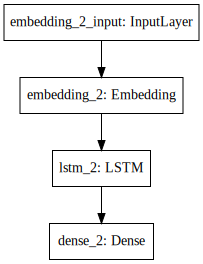

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 300)         18000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
Total params: 18,404,820
Trainable params: 404,820
Non-trainable params: 18,000,000
_________________________________________________________________


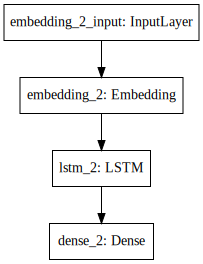

Train on 11314 samples, validate on 7532 samples
Epoch 1/100
11314/11314 [==============================] - 1648s 146ms/step - loss: 0.9284 - acc: 0.0526 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 2/100
11314/11314 [==============================] - 1612s 142ms/step - loss: 1.1921e-07 - acc: 0.0424 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 3/100
11314/11314 [==============================] - 1625s 144ms/step - loss: 1.1921e-07 - acc: 0.0424 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 4/100
11314/11314 [==============================] - 1701s 150ms/step - loss: 1.1921e-07 - acc: 0.0424 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 5/100
11314/11314 [==============================] - 1651s 146ms/step - loss: 1.1921e-07 - acc: 0.0424 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 6/100
11314/11314 [==============================] - 1661s 147ms/step - loss: 1.1921e-07 - acc: 0.0424 - val_loss: 1.1921e-07 - val_acc: 0.0424
Epoch 7/100
11314/11314 [==============================

KeyboardInterrupt: 

In [15]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('20newsgroups') # 20newsgroups reuters
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_sequences(docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')

# model_20newsgroups = build_RNN_model('20newsgroups')
# model_20newsgroups.save('Model/news_rnn_300_2.h5')

# epochs/accuracy/TestAccuracy: 100/0.9267/0.75912;
model = load_model('Model/news_rnn_300_2.h5')
model.summary()
display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.fit(x_train_m, y_train_m,
          batch_size=128,
          epochs=100,
          validation_data = (x_test_m, y_test_m))
model.save('Model/news_rnn_300_2.h5')

# test the trained model
score = model.evaluate(x_test_m, y_test_m, batch_size = 128, verbose = 1)
print('\nTest score:', score[0], 'Test accuracy:', score[1])

Loading reuters dataset...
8982 train docs 8982
2246 test docs 2246
8982 training documents are loaded.
2246 test documents are loaded.

Found 30976 unique tokens.
Shape of x_train_m: (8982, 2000)
Shape of y_train_m: (8982, 46)
Shape of x_test_m: (2246, 2000)
Shape of y_test_m: (2246, 46)
46 targets

Loading reuters dataset...
8982 train docs 8982
2246 test docs 2246
8982 training documents are loaded.
2246 test documents are loaded.

Found 30976 unique tokens.
Preparing embedding matrix
Building RNN model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 300)         9292800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dense_1 (Dense)              (None, 46)                9246      
Total params: 9,702,846
Tr

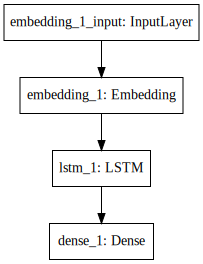

Train on 8982 samples, validate on 2246 samples
Epoch 1/100
8982/8982 [==============================] - 1274s 142ms/step - loss: 0.1163 - acc: 0.0102 - val_loss: 1.1921e-07 - val_acc: 0.0053
Epoch 2/100
8982/8982 [==============================] - 1214s 135ms/step - loss: 1.1921e-07 - acc: 0.0061 - val_loss: 1.1921e-07 - val_acc: 0.0053
Epoch 3/100
8982/8982 [==============================] - 1241s 138ms/step - loss: 1.1921e-07 - acc: 0.0061 - val_loss: 1.1921e-07 - val_acc: 0.0053
Epoch 4/100
 128/8982 [..............................] - ETA: 18:59 - loss: 1.1921e-07 - acc: 0.0078

KeyboardInterrupt: 

In [14]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('reuters') # 20newsgroups reuters
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_sequences(docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')

model_reuters = build_RNN_model('reuters') # 20newsgroups reuters
model_reuters.save('Model/reuter_rnn_300_2.h5')

# epochs/accuracy/TestAccuracy: 100/0.9267/0.75912;
model = load_model('Model/reuter_rnn_300_2.h5')
model.summary()
display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.fit(x_train_m, y_train_m,
          batch_size=128,
          epochs=100,
          validation_data = (x_test_m, y_test_m))
model.save('Model/reuter_rnn_300_2.h5')

# test the trained model
score = model.evaluate(x_test_m, y_test_m, batch_size = 128, verbose = 1)
print('\nTest score:', score[0], 'Test accuracy:', score[1])

# Part 3 Convolutional Neural Network With Word Embeddings

In [16]:
def build_CNN_model(dataset): # 20newsgroups reuters
    [docs_train, y_train, docs_test, y_test, target_names] = load_dataset(dataset)
    MAX_NB_WORDS = 60000
    
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    docs = []
    docs.extend(docs_train)
    docs.extend(docs_test)
    tokenizer.fit_on_texts(docs)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    # Prepare embedding matrix
    print('Preparing embedding matrix')
    num_words = min(vocab_size, len(word_index))
    print('num_words =', num_words)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # set trainable = False to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)

    # train a 1D convnet with global maxpooling
    print('Building CNN model')
    drop_rate = 0.6
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    # rate: float between 0 and 1. Fraction of the input units to drop.
    model.add(Dropout(drop_rate))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Dropout(drop_rate))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(len(target_names), activation='softmax'))
    # Choose the optimizer
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', # sgd rmsprop
                  metrics=['acc'])

    model.summary()
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    return model

### 3.1 CNN Model Trained With 20 Newsgroup Dataset and 300 Dim Word Embedding

11314 training documents are loaded.
7532 test documents are loaded.

Found 179209 unique tokens.
Shape of x_train_m: (11314, 2000)
Shape of y_train_m: (11314, 20)
Shape of x_test_m: (7532, 2000)
Shape of y_test_m: (7532, 20)
20 targets

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 300)         18000000  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1996, 128)         192128    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 399, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 395, 128)          82048     
____________________________________

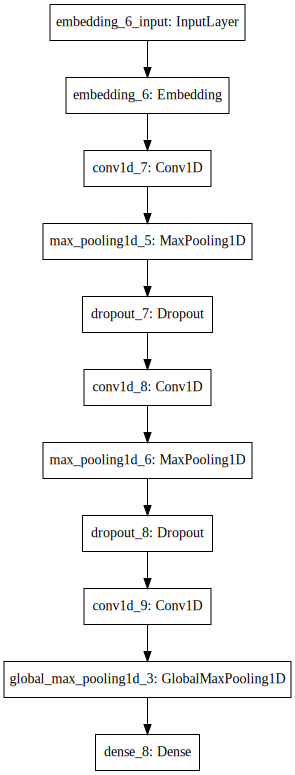

Train on 11314 samples, validate on 7532 samples
Epoch 1/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0775 - acc: 0.9779 - val_loss: 0.8466 - val_acc: 0.8401
Epoch 2/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0919 - acc: 0.9763 - val_loss: 0.8625 - val_acc: 0.8342
Epoch 3/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0851 - acc: 0.9750 - val_loss: 0.8263 - val_acc: 0.8396
Epoch 4/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0642 - acc: 0.9803 - val_loss: 0.9105 - val_acc: 0.8317
Epoch 5/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0775 - acc: 0.9795 - val_loss: 0.8494 - val_acc: 0.8388
Epoch 6/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0848 - acc: 0.9773 - val_loss: 0.8332 - val_acc: 0.8408
Epoch 7/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0763 - acc: 0.9774 - val_lo

Epoch 59/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0624 - acc: 0.9822 - val_loss: 0.9094 - val_acc: 0.8366
Epoch 60/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0667 - acc: 0.9838 - val_loss: 0.9748 - val_acc: 0.8303
Epoch 61/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0881 - acc: 0.9795 - val_loss: 0.9488 - val_acc: 0.8370
Epoch 62/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0656 - acc: 0.9842 - val_loss: 0.8959 - val_acc: 0.8407
Epoch 63/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0751 - acc: 0.9801 - val_loss: 0.9449 - val_acc: 0.8370
Epoch 64/100
11314/11314 [==============================] - 184s 16ms/step - loss: 0.0692 - acc: 0.9815 - val_loss: 0.9364 - val_acc: 0.8403
Epoch 65/100
11314/11314 [==============================] - 185s 16ms/step - loss: 0.0600 - acc: 0.9834 - val_loss: 0.9697 - val_acc: 0.8366
Epoch 66/100


In [7]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('20newsgroups') # 20newsgroups
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_sequences(docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')

# model_20newsgroups = build_CNN_model('20newsgroups') # 20newsgroups reuters
# model_20newsgroups.save('Model/news_cnn_300_2.h5')

# epochs/accuracy/TestAccuracy: 100/0.9771/0.8341;
model = load_model('Model/news_cnn_300_2.h5') #news_cnn_300_2
model.summary()
display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.fit(x_train_m, y_train_m,
          batch_size=128,
          epochs=100,
          validation_data = (x_test_m, y_test_m))
model.save('Model/news_cnn_300_2.h5')

# test the trained model
score = model.evaluate(x_test_m, y_test_m, batch_size = 128, verbose = 1)
print('\nTest score:', score[0], 'Test accuracy:', score[1])

### 3.2 CNN Model Trained With Reuter Dataset and 300 Dim Word Embedding

Loading reuters dataset...
8982 train docs 8982
2246 test docs 2246
8982 training documents are loaded.
2246 test documents are loaded.

Found 30976 unique tokens.
Shape of x_train_m: (8982, 2000)
Shape of y_train_m: (8982, 46)
Shape of x_test_m: (2246, 2000)
Shape of y_test_m: (2246, 46)
46 targets

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 300)         9292800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1996, 128)         192128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 399, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 399, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39

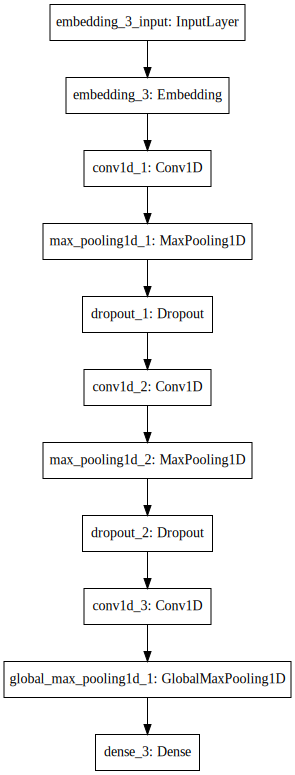

Train on 8982 samples, validate on 2246 samples
Epoch 1/80
8982/8982 [==============================] - 179s 20ms/step - loss: 0.1597 - acc: 0.9511 - val_loss: 1.5697 - val_acc: 0.7404
Epoch 2/80
8982/8982 [==============================] - 178s 20ms/step - loss: 0.1504 - acc: 0.9534 - val_loss: 1.6105 - val_acc: 0.7297
Epoch 3/80
8982/8982 [==============================] - 179s 20ms/step - loss: 0.1592 - acc: 0.9503 - val_loss: 1.6006 - val_acc: 0.7462
Epoch 4/80
8982/8982 [==============================] - 178s 20ms/step - loss: 0.1595 - acc: 0.9507 - val_loss: 1.6023 - val_acc: 0.7582
Epoch 5/80
8982/8982 [==============================] - 177s 20ms/step - loss: 0.1651 - acc: 0.9521 - val_loss: 1.6222 - val_acc: 0.7484
Epoch 6/80
8982/8982 [==============================] - 177s 20ms/step - loss: 0.1555 - acc: 0.9510 - val_loss: 1.6273 - val_acc: 0.7582
Epoch 7/80
8982/8982 [==============================] - 177s 20ms/step - loss: 0.1564 - acc: 0.9516 - val_loss: 1.5947 - val_acc: 

ResourceExhaustedError: OOM when allocating tensor with shape[128,300,1,2000]
	 [[Node: training_1/RMSprop/gradients/conv1d_1_1/convolution/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@conv1d_1_1/convolution/Conv2D"], data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/RMSprop/gradients/conv1d_1_1/convolution/Conv2D_grad/ShapeN, conv1d_1_1/convolution/ExpandDims_1, training_1/RMSprop/gradients/conv1d_1_1/convolution/Squeeze_grad/Reshape)]]

Caused by op 'training_1/RMSprop/gradients/conv1d_1_1/convolution/Conv2D_grad/Conv2DBackpropInput', defined at:
  File "C:\Users\WangYong\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\WangYong\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-037dde95403b>", line 9, in <module>
    model = load_model('Model/reuter_cnn_300_2.h5') #reuter_cnn_300_2
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\models.py", line 276, in load_model
    model.model._make_train_function()
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\optimizers.py", line 225, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\optimizers.py", line 73, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2369, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 474, in _Conv2DGrad
    data_format),
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 778, in conv2d_backprop_input
    use_cudnn_on_gpu=use_cudnn_on_gpu, data_format=data_format, name=name)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'conv1d_1_1/convolution/Conv2D', defined at:
  File "C:\Users\WangYong\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-4-037dde95403b>", line 9, in <module>
    model = load_model('Model/reuter_cnn_300_2.h5') #reuter_cnn_300_2
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\layers\__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\models.py", line 1249, in from_config
    model.add(layer)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\models.py", line 475, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 156, in call
    dilation_rate=self.dilation_rate[0])
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3147, in conv1d
    data_format=tf_data_format)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 187, in __call__
    name=self.name)
  File "C:\Users\WangYong\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 177, in _conv1d
    data_format=data_format, name=name)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,300,1,2000]
	 [[Node: training_1/RMSprop/gradients/conv1d_1_1/convolution/Conv2D_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@conv1d_1_1/convolution/Conv2D"], data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/RMSprop/gradients/conv1d_1_1/convolution/Conv2D_grad/ShapeN, conv1d_1_1/convolution/ExpandDims_1, training_1/RMSprop/gradients/conv1d_1_1/convolution/Squeeze_grad/Reshape)]]


In [4]:
[docs_train, y_train, docs_test, y_test, target_names] = load_dataset('reuters') # reuters
x_train_m, y_train_m, x_test_m, y_test_m = doc_2_sequences(docs_train, y_train, docs_test, y_test)
print(len(target_names), 'targets\n')

# model_reuters = build_CNN_model('reuters') # 20newsgroups reuters
# model_reuters.save('Model/reuter_cnn_300_2.h5')

# epochs/accuracy/TestAccuracy: 100/0.9529/0.7399; 180/0.9529/0.7399;
model = load_model('Model/reuter_cnn_300_2.h5') #reuter_cnn_300_2
model.summary()
display(SVG(model_to_dot(model).create(prog='dot', format='svg')))

model.fit(x_train_m, y_train_m,
          batch_size=128,
          epochs=80,
          validation_data = (x_test_m, y_test_m))
model.save('Model/reuter_cnn_300_2.h5')

# test the trained model
score = model.evaluate(x_test_m, y_test_m, batch_size = 128, verbose = 1)
print('\nTest score:', score[0], 'Test accuracy:', score[1])

# Part 4 Doc2Vector
Build the unsupervised model PV_DM

# Load the Reuters and 20newsgroup Datasets

In [3]:
[news_docs_train, news_docs_test, news_y_train, news_y_test, news_target_names] = load_dataset('20newsgroups') # reuters or 20newsgroups
[reuters_docs_train, reuters_docs_test, reuters_y_train, reuters_y_test, reuters_target_names] = load_dataset('reuters') # reuters or 20newsgroups

11314 training documents are loaded.
7532 testing documents are loaded.

7769 training documents are loaded.
3019 testing documents are loaded.



In [4]:
input_file = open('alldata.txt', 'w')

id_ = 0
for doc in news_docs_train:
    doc_id = 'news_train_%i' % id_
    id_ = id_ + 1
    tokens = nltk.word_tokenize(doc)
    doc_tokens = ' '.join(tokens).lower()
    doc_tokens = doc_tokens.encode('ascii', 'ignore')
    input_file.write('%s %s\n' % (doc_id, doc_tokens))
print(id_, "news group doc for training")
    
id_ = 0
for doc in news_docs_test:
    doc_id = 'news_test_%i' % id_
    id_ = id_ + 1
    tokens = nltk.word_tokenize(doc)
    doc_tokens = ' '.join(tokens).lower()
    doc_tokens = doc_tokens.encode('ascii', 'ignore')
    input_file.write('%s %s\n' % (doc_id, doc_tokens))
print(id_, "news group doc for test")
    
id_ = 0
for doc in reuters_docs_train:
    doc_id = 'reuters_train_%i' % id_
    id_ = id_ + 1
    tokens = nltk.word_tokenize(doc)
    doc_tokens = ' '.join(tokens).lower()
    doc_tokens = doc_tokens.encode('ascii', 'ignore')
    input_file.write('%s %s\n' % (doc_id, doc_tokens))
print(id_, "reuters doc for training")
    
id_ = 0
for doc in reuters_docs_test:
    doc_id = 'reuters_test_%i' % id_
    id_ = id_ + 1
    tokens = nltk.word_tokenize(doc)
    doc_tokens = ' '.join(tokens).lower()
    doc_tokens = doc_tokens.encode('ascii', 'ignore')
    input_file.write('%s %s\n' % (doc_id, doc_tokens))
print(id_, "reuters doc for test")
    
input_file.close()

11314 news group doc for training
7532 news group doc for test
7769 reuters doc for training
3019 reuters doc for test


In [11]:
docList = []

for idx in range(len(news_docs_train)):
    docList.append('news_train_' + str(idx))

for idx in range(len(news_docs_test)):
    docList.append('news_test_' + str(idx))

for idx in range(len(reuters_docs_train)):
    docList.append('reuters_train_' + str(idx))
    
for idx in range(len(reuters_docs_test)):
    docList.append('reuters_test_' + str(idx))

print(len(docList))
docList = set(docList)
print(len(docList))

29634
29634


In [36]:
def load_pretrain_doc_voc():
    print('Loading pretrained documents Vectors')
    doc_vector = {}
    f = open(os.path.join('Model', 'vectors300.txt'), "r") # vectors100.txt vectors300.txt
    for line in f:
        values = line.split()
        word = values[0]
        if word in docList:
            coefs = np.array([float(x) for x in values[1].split(',')])
            doc_vector[word] = coefs
    f.close()
    return doc_vector

doc_vector = load_pretrain_doc_voc()
print('%s document vectors are loaded.' % len(doc_vector))

news_x_train = []
for idx in range(len(news_docs_train)):
    news_x_train.append(doc_vector['news_train_' + str(idx)])
print(len(news_x_train), 'news training examples')

news_x_test = []
for idx in range(len(news_docs_test)):
    news_x_test.append(doc_vector['news_test_' + str(idx)])
print(len(news_x_test), 'news training examples')

print(len(news_x_test[0]))

Loading pretrained documents Vectors
29634 document vectors are loaded.
11314 news training examples
7532 news training examples
300


In [37]:
print("Starting test pretrained document vector for document classification:")
X = news_x_train
y = news_y_train
C1 = [8, 16, 32, 64, 128, 256]
X_test = news_x_test
y_test = news_y_test
C2 = [0.01, 0.05, 0.5, 1.0, 2.0, 4.0]
svm_test(X, y, C1, X_test, y_test, C2)

Starting test pretrained document vector for document classification:
RBF:Correct rate = 0.7006107275624005 When C = 8
RBF:Correct rate = 0.7282262347318109 When C = 16
RBF:Correct rate = 0.7338024429102497 When C = 32
RBF:Correct rate = 0.7430961232076474 When C = 64
RBF:Correct rate = 0.7458842272968667 When C = 128
RBF:Correct rate = 0.74429102496017 When C = 256
Linear:Correct rate = 0.7138874137015401 When C = 0.01
Linear:Correct rate = 0.7400424853956453 When C = 0.05
Linear:Correct rate = 0.7497344662772172 When C = 0.5
Linear:Correct rate = 0.7482740308019118 When C = 1.0
Linear:Correct rate = 0.7458842272968667 When C = 2.0
Linear:Correct rate = 0.739644184811471 When C = 4.0


## Part 4.2 Training Doc2Vec using gensim


In [4]:
import gensim

# Define a Function to Preprocess Text
def create_training_data_set():
    
    train_corpus = []
    for idx in range(len(news_docs_train)):
        # For training data, add tags
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(news_docs_train[idx]),
                                                                 ['news_train_' + str(idx)]))
    
    for idx in range(len(news_docs_test)):
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(news_docs_test[idx]),
                                                                 ['news_test_' + str(idx)]))
    
    for idx in range(len(reuters_docs_train)):
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(reuters_docs_train[idx]),
                                                                 ['reuters_train_' + str(idx)]))
    
    for idx in range(len(reuters_docs_test)):
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(reuters_docs_test[idx]),
                                                                 ['reuters_test_' + str(idx)]))
    return train_corpus

# load training files and test files
train_corpus = create_training_data_set()

# show first two training data
print(train_corpus[0])
print(news_docs_train[0])

C:\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[TaggedDocument(words=['from', 'lerxst', 'wam', 'umd', 'edu', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neig

In [21]:
# Define the Doc2Vec model
# with a vector size with 50 words and iterating over the training corpus 55 times
# set the minimum word count to 2 in order to give higher frequency words more weighting
# Model accuracy can be improved by increasing the number of iterations
model = gensim.models.doc2vec.Doc2Vec(dm = 1, dm_concat = 1, size=300, window=10, min_count=2, negative=10, iter=100, workers = 4)
model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)
model.save("Model/gensim300")

Wall time: 3h 31min 58s


In [22]:
# Test document vector generated by gensim for document classification
# model = Doc2Vec.load(fname)
doc_vector = model.docvecs

news_x_train = []
for idx in range(len(news_docs_train)):
    news_x_train.append(doc_vector['news_train_' + str(idx)])
print(len(news_x_train), 'news training examples')

news_x_test = []
for idx in range(len(news_docs_test)):
    news_x_test.append(doc_vector['news_test_' + str(idx)])
print(len(news_x_test), 'news training examples')

print("Starting test document vector generated by gensim for document classification:")
X = news_x_train
y = news_y_train
X_test = news_x_test
y_test = news_y_test
svm_test(X, y, X_test, y_test)

11314 news training examples
7532 news training examples
Starting test document vector generated by gensim for document classification:
RBF:Correct rate = 0.3332448220924057 When C = 0.5
RBF:Correct rate = 0.35661178969729157 When C = 1.0
RBF:Correct rate = 0.37121614445034523 When C = 2.0
RBF:Correct rate = 0.38528943175783326 When C = 4.0
RBF:Correct rate = 0.4013542219861922 When C = 8.0
RBF:Correct rate = 0.40693043016463093 When C = 16
RBF:Correct rate = 0.41768454593733406 When C = 32
RBF:Correct rate = 0.42644715878916617 When C = 64
RBF:Correct rate = 0.435740839086564 When C = 128
RBF:Correct rate = 0.4403876792352629 When C = 256
Linear:Correct rate = 0.5130111524163569 When C = 0.5
Linear:Correct rate = 0.5289431757833245 When C = 1.0
Linear:Correct rate = 0.5426181625066384 When C = 2.0
Linear:Correct rate = 0.5524429102496017 When C = 4.0
Linear:Correct rate = 0.5584174190122145 When C = 8.0
Linear:Correct rate = 0.5606744556558683 When C = 16
Linear:Correct rate = 0.55390